In [1]:
import sys
sys.path.append(r"D:\3ACS\TDL\lipEstimation")
from lipschitz_utils import *
from models.pinn_spring import pinn_spring
from models.pinn_field import pinn_field
from lipschitz_approximations import *


In [23]:
import numpy as np
def compute_alignment(model):
    params = [param for param in model.parameters() if param.ndim > 1]
    alignments = []
    for i in range(len(params) - 1):
        u1, s, _ = torch.svd(params[i])
        _, _, v2 = torch.svd(params[i + 1])
        try:
            print(f'Ratio = {s[1]/s[0]:.2f}')
        except:
            print(f"First singular = {s[0]:.2f}")
        # print(f'Highest sing = {s[0]}')
        print(u1.shape, v2.shape)
        alignment = torch.abs(torch.nn.functional.cosine_similarity(u1[:, 0], v2.T[:, 0], dim=0)).item()
        alignments.append(alignment)
    return alignments

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.nn.utils import parameters_to_vector

# Helper function to perform SVD and return singular values
def compute_singular_values(weight_matrix):
    u, s, v = torch.svd(weight_matrix)
    return s.detach().numpy()

# Helper function to plot weight histograms
def plot_weight_histograms(pinn, mlp):
    """
    Plot weight histograms layer by layer for comparison between PINN and MLP.

    Args:
        pinn: The PINN model.
        mlp: The MLP model.
    """
    pinn_params = [param for param in pinn.parameters() if param.ndim > 1]
    mlp_params = [param for param in mlp.parameters() if param.ndim > 1]
    
    # Ensure the models have the same number of layers to compare
    assert len(pinn_params) == len(mlp_params), "PINN and MLP must have the same number of layers."
    
    fig,axs = plt.subplots(1,len(pinn_params), figsize=(12,5))

    for i, (pinn_layer, mlp_layer) in enumerate(zip(pinn_params, mlp_params)):
        pinn_weights = pinn_layer.flatten().detach().numpy()
        mlp_weights = mlp_layer.flatten().detach().numpy()
        
        axs[i].hist(pinn_weights, bins=50, alpha=0.6, label='PINN', color='blue')
        axs[i].hist(mlp_weights, bins=50, alpha=0.6, label='MLP', color='orange')
        axs[i].set_title(f'Layer {i + 1}')
        # axs[i].set_xlabel('Weight values')
        # axs[i].set_ylabel('Frequency')
        axs[i].legend()
        # plt.show()
    plt.show()

# Helper function to plot singular value distributions
def plot_singular_values(pinn, mlp):
    """
    Plot singular values layer by layer for comparison between PINN and MLP.

    Args:
        pinn: The PINN model.
        mlp: The MLP model.
    """
    pinn_params = [param for param in pinn.parameters() if param.ndim > 1]
    mlp_params = [param for param in mlp.parameters() if param.ndim > 1]
    
    # Ensure the models have the same number of layers to compare
    assert len(pinn_params) == len(mlp_params), "PINN and MLP must have the same number of layers."
    
    for i, (pinn_layer, mlp_layer) in enumerate(zip(pinn_params, mlp_params)):
        # Compute singular values for the current layer
        pinn_singular_values = compute_singular_values(pinn_layer)
        mlp_singular_values = compute_singular_values(mlp_layer)
        
        # Plot singular values for this layer
        plt.scatter(range(len(pinn_singular_values)),np.sort(pinn_singular_values)[::-1], label='PINN', color='blue')
        plt.scatter(range(len(mlp_singular_values)), np.sort(mlp_singular_values)[::-1], label='MLP', color='orange')
        plt.yscale('log')
        plt.title(f'Layer {i + 1} - Singular Values Comparison (log scale)')
        plt.xlabel('Index')
        plt.ylabel('Singular Value (log)')
        plt.legend()
        plt.show()


# Helper function to compare activations layer by layer
def compare_activations(pinn, mlp, inputs, layer_index=0):
    pinn_layer = pinn.layers[layer_index]
    mlp_layer = mlp.layers[layer_index]
    
    with torch.no_grad():
        pinn_activation = pinn_layer(inputs)
        mlp_activation = mlp_layer(inputs)
    
    plt.plot(pinn_activation.detach().numpy(), label='PINN', color='blue')
    plt.plot(mlp_activation.detach().numpy(), label='MLP', color='orange')
    plt.title(f'Layer {layer_index} - Activation Comparison')
    plt.legend()
    plt.show()

# Helper function to compare weight sensitivity
def plot_weight_sensitivity(pinn, mlp, inputs):
    inputs.requires_grad = True
    
    # Compute gradients for PINN
    pinn_outputs = pinn(inputs)
    pinn_grads = torch.autograd.grad(pinn_outputs.sum(), pinn.parameters(), create_graph=False)
    pinn_sensitivities = [grad.abs().mean().item() for grad in pinn_grads if grad.ndim > 1]
    
    # Compute gradients for MLP
    mlp_outputs = mlp(inputs)
    mlp_grads = torch.autograd.grad(mlp_outputs.sum(), mlp.parameters(), create_graph=False)
    mlp_sensitivities = [grad.abs().mean().item() for grad in mlp_grads if grad.ndim > 1]
    
    x = np.arange(len(pinn_sensitivities))
    plt.bar(x - 0.2, pinn_sensitivities, width=0.4, label='PINN', color='blue')
    plt.bar(x + 0.2, mlp_sensitivities, width=0.4, label='MLP', color='orange')
    plt.title('Weight Sensitivity Comparison')
    plt.xlabel('Layer Index')
    plt.ylabel('Mean Absolute Sensitivity')
    plt.legend()
    plt.show()

def analyze_singular_vector_alignment(pinn, mlp):
    """
    Analyze and plot the alignment of singular vectors between PINN and MLP layers.

    Args:
        pinn: The PINN model.
        mlp: The MLP model.
    """
    pinn_params = [param for param in pinn.parameters() if param.ndim > 1]
    mlp_params = [param for param in mlp.parameters() if param.ndim > 1]
    
    # Ensure the models have the same number of layers to compare
    assert len(pinn_params) == len(mlp_params), "PINN and MLP must have the same number of layers."
    
    alignment_scores = []  # Store cosine similarity for each layer
    for i, (pinn_layer, mlp_layer) in enumerate(zip(pinn_params, mlp_params)):
        # Perform SVD on both layers
        pinn_u, _, _ = torch.svd(pinn_layer)
        mlp_u, _, _ = torch.svd(mlp_layer)
        
        # Compute cosine similarity between the singular vectors
        similarities = []
        for j in range(pinn_u.shape[1]):
            similarity = torch.nn.functional.cosine_similarity(pinn_u[:, j], mlp_u[:, j], dim=0).item()
            similarities.append(similarity)
        
        # Average alignment score for this layer
        alignment_scores.append(np.mean(similarities))
        
        # Plot cosine similarities for individual singular vectors
        plt.plot(similarities, label=f'Layer {i + 1}', marker='o')
    
    plt.title('Alignment of Singular Vectors (Cosine Similarity)')
    plt.xlabel('Singular Vector Index')
    plt.ylabel('Cosine Similarity')
    plt.legend()
    plt.grid()
    plt.show()
    
    # Overall alignment score summary
    plt.bar(range(1, len(alignment_scores) + 1), alignment_scores, color='blue', alpha=0.7)
    plt.title('Average Singular Vector Alignment by Layer')
    plt.xlabel('Layer Index')
    plt.ylabel('Average Cosine Similarity')
    plt.grid()
    plt.show()



# Example usage: Compare PINN and MLP
def compare_pinn_mlp(pinn, mlp, input_data):
    # 1. Plot weight histograms
    plot_weight_histograms(pinn, mlp)
    
    # 2. Plot singular value distributions
    # plot_singular_values(pinn, mlp)
    
    # 3. Compare activations for the first few layers
    # for layer_index in range(3):  # Adjust the range based on your model depth
    #     compare_activations(pinn, mlp, input_data, layer_index)
    
    # 4. Plot weight sensitivity
    # plot_weight_sensitivity(pinn, mlp, input_data.clone())

    # analyze_singular_vector_alignment(pinn,mlp)

# Instantiate models

In [4]:
import matplotlib.pyplot as plt

def plot_traj(model):
    t = np.linspace(0,3,1000)
    x = model(torch.tensor(t, dtype=torch.float).unsqueeze(1)).detach()
    xdot = torch.gradient(x.squeeze(1),spacing = (torch.tensor(t, dtype=torch.float),))[0]
    true_sol = model.system.get_solution(t)
    plt.plot(t,x)
    plt.plot(t,true_sol, linestyle="--")

    plt.plot(t,xdot)
    plt.plot(t,model.system.get_first_derivatives(t), linestyle="--")
    plt.show()

In [5]:
def compute_lipschitz_approximations(model, input_size):
    print(model)
    # Don't compute gradient for the projector: speedup computations
    for p in model.parameters():
        p.requires_grad = False

    # Compute input sizes for all modules of the model
    compute_module_input_sizes(model, input_size)

    # Lipschitz lower bound through optimization of the gradient norm
    print('Computing lip_opt...')
    lip_opt = lipschitz_annealing(model, n_iter=1000, temp=1, batch_size=1).item()

    # Lipschitz upper bound using the product of spectral norm
    print('Computing lip_spec...')
    lip_spec = lipschitz_spectral_ub(model).data[0].item()

    # Lipschitz upper bound using the product of Frobenius norm
    print('Computing lip_frob...')
    lip_frob = lipschitz_frobenius_ub(model).data[0].item()

    print('Computing lip_secorder greedy...')
    lip_secorder_greedy = lipschitz_second_order_ub(model, algo='greedy')

    print('Computing lip_secorder BFGS...')
    lip_secorder_bfgs = lipschitz_second_order_ub(model, algo='bfgs')
    return {"Annealing lb": lip_opt,
            "Spectral ub": lip_spec,
            "Frobenius ub": lip_frob,
            "Seqlip greedy": lip_secorder_greedy,
            "Seqlip bfgs": lip_secorder_bfgs}

In [6]:
mlp_s = pinn_spring(loc=r"D:\3ACS\TDL\lipEstimation\models_ckpts\mlp_spring.pth")
print("True lip: ", mlp_s.system.estimate_lipschitz_constant(0,3))
pinn_s = pinn_spring(loc=r"D:\3ACS\TDL\lipEstimation\models_ckpts\pinn_spring.pth")
lips_mlp_s = compute_lipschitz_approximations(mlp_s, [1,1])
lips_pinn_s = compute_lipschitz_approximations(pinn_s, [1,1])

True lip:  2.5174379039435624
MLP(
  (criterion): MSELoss()
  (layers): Sequential(
    (0): Linear(in_features=1, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=32, bias=True)
    (7): ReLU()
    (8): Linear(in_features=32, out_features=1, bias=True)
  )
)
Computing lip_opt...
 => New maximum: 1.7383 step size: 0.7071
[0] Best: 1.7383 (moves: 0/1, T: 1.44) (max: 1.7383)
 => New maximum: 1.7461 step size: 0.5774
[1] Best: 1.7461 (moves: 0/1, T: 1.09) (max: 1.7461)
[2] Best: 1.7461 (moves: 0/1, T: 0.91) (max: 1.7461)
[3] Best: 0.7500 (moves: 1/1, T: 0.80) (max: 1.7461)
[4] Best: 0.7500 (moves: 0/1, T: 0.72) (max: 1.7461)
 => New maximum: 1.7852 step size: 0.5000
[5] Best: 1.7852 (moves: 1/1, T: 0.66) (max: 1.7852)
[6] Best: 1.7852 (moves: 0/1, T: 0.62) (max: 1.7852)
 => New maximum: 1.7891 step s

d:\anaconda3\envs\dl_env\lib\site-packages\torch\nn\modules\module.py:1053: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


factor 0.5078635821941063
ratio s 0.8329055
factor abs prod: 0.5575159857653489
factor 0.5511820437946341
ratio s 0.843549
factor abs prod: 0.7928874950448517
factor 0.6293421882389737
MLP(
  (criterion): MSELoss()
  (layers): Sequential(
    (0): Linear(in_features=1, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=32, bias=True)
    (7): ReLU()
    (8): Linear(in_features=32, out_features=1, bias=True)
  )
)
Computing lip_opt...
 => New maximum: 0.4609 step size: 0.7071
[0] Best: 0.4609 (moves: 0/1, T: 1.44) (max: 0.4609)
 => New maximum: 2.0625 step size: 0.5774
[1] Best: 2.0625 (moves: 1/1, T: 1.09) (max: 2.0625)
[2] Best: 0.4531 (moves: 1/1, T: 0.91) (max: 2.0625)
[3] Best: 0.5625 (moves: 1/1, T: 0.80) (max: 2.0625)
[4] Best: 0.2266 (moves: 1/1, T: 0.72) (max: 2.0625)
[5] Best: 0.3203 (moves

In [7]:
print(lips_mlp_s)
print(lips_pinn_s)

{'Annealing lb': 4.8046875, 'Spectral ub': 298.5403137207031, 'Frobenius ub': 1623.724853515625, 'Seqlip greedy': 53.31563760994974, 'Seqlip bfgs': 52.593488587516944}
{'Annealing lb': 2.8046875, 'Spectral ub': 82.81108093261719, 'Frobenius ub': 570.4132690429688, 'Seqlip greedy': 15.729535414129504, 'Seqlip bfgs': 13.204003283795503}


PINN
First singular = 3.36
torch.Size([32, 1]) torch.Size([32, 32])
Ratio = 0.80
torch.Size([32, 32]) torch.Size([32, 32])
Ratio = 0.90
torch.Size([32, 32]) torch.Size([32, 32])
Ratio = 0.67
torch.Size([32, 32]) torch.Size([32, 1])
MLP
First singular = 3.00
torch.Size([32, 1]) torch.Size([32, 32])
Ratio = 0.54
torch.Size([32, 32]) torch.Size([32, 32])
Ratio = 0.83
torch.Size([32, 32]) torch.Size([32, 32])
Ratio = 0.84
torch.Size([32, 32]) torch.Size([32, 1])
Cumulative similarities : MLP 0.0006999530182104878 || PINN 2.369548160982731e-05


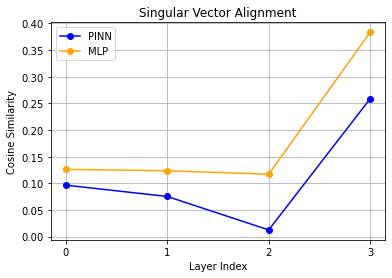

In [24]:
print("PINN")
pinn_alignment = compute_alignment(pinn_s)
print("MLP")
mlp_alignment = compute_alignment(mlp_s)

print(f"Cumulative similarities : MLP {np.prod(mlp_alignment)} || PINN {np.prod(pinn_alignment)}" )

plt.plot(range(len(pinn_alignment)), pinn_alignment, label='PINN', marker='o', color='blue')
plt.plot(range(len(mlp_alignment)), mlp_alignment, label='MLP', marker='o', color='orange')
plt.title('Singular Vector Alignment')
plt.xlabel('Layer Index')
plt.ylabel('Cosine Similarity')
plt.legend()
plt.grid("on")
plt.xticks(ticks=range(len(pinn_alignment)))
plt.show()

In [14]:
mlp_tiny = pinn_field(loc=r"D:\3ACS\TDL\lipEstimation\models_ckpts\mlp_field_tiny.pth", size = "tiny")
pinn_tiny = pinn_field(loc=r"D:\3ACS\TDL\lipEstimation\models_ckpts\pinn_field_tiny.pth", size = "tiny")
ridge_tiny = pinn_field(loc=r"D:\3ACS\TDL\lipEstimation\models_ckpts\ridge_field_tiny.pth", size = "tiny")
lips_mlp_tiny = compute_lipschitz_approximations(mlp_tiny, [1,2])
lips_pinn_tiny = compute_lipschitz_approximations(pinn_tiny, [1,2])
lips_ridge_tiny = compute_lipschitz_approximations(ridge_tiny, [1,2])

NewPlanetsModel(
  (fc): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): Tanh()
    (6): Linear(in_features=64, out_features=64, bias=True)
    (7): Tanh()
    (8): Linear(in_features=64, out_features=1, bias=True)
  )
)
Computing lip_opt...
 => New maximum: 4.1484 step size: 0.7071
[0] Best: 4.1484 (moves: 0/1, T: 1.44) (max: 4.1484)
[1] Best: 4.1484 (moves: 0/1, T: 1.09) (max: 4.1484)
 => New maximum: 6.9766 step size: 0.5774
[2] Best: 6.9766 (moves: 1/1, T: 0.91) (max: 6.9766)
[3] Best: 6.9766 (moves: 0/1, T: 0.80) (max: 6.9766)
 => New maximum: 7.0566 step size: 0.5000
[4] Best: 7.0566 (moves: 0/1, T: 0.72) (max: 7.0566)
[5] Best: 7.0566 (moves: 0/1, T: 0.66) (max: 7.0566)
 => New maximum: 7.7969 step size: 0.4472
[6] Best: 7.7969 (moves: 1/1, T: 0.62) (max: 7.7969)
 => New maximum: 9.7695 step size: 

d:\anaconda3\envs\dl_env\lib\site-packages\torch\nn\modules\module.py:1053: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


factor 0.4934454440426235
ratio s 0.70436597
factor abs prod: 0.42283283827418927
factor 0.5230910270914361
Computing lip_secorder BFGS...
ratio s 0.9311575
factor abs prod: 0.7403906257386552
factor 0.5609872739847113
ratio s 0.8298825
factor abs prod: 0.6251891149731819
factor 0.49322510412986914
ratio s 0.70436597
factor abs prod: 0.42283283827418927
factor 0.5222092107130851
NewPlanetsModel(
  (fc): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): Tanh()
    (6): Linear(in_features=64, out_features=64, bias=True)
    (7): Tanh()
    (8): Linear(in_features=64, out_features=1, bias=True)
  )
)
Computing lip_opt...
 => New maximum: 0.5898 step size: 0.7071
[0] Best: 0.5898 (moves: 0/1, T: 1.44) (max: 0.5898)
 => New maximum: 0.7891 step size: 0.5774
[1] Best: 0.7891 (moves: 1/1, T: 1.09) (max: 0.7891)
[2

In [28]:
print("MLP: ", lips_mlp_tiny)
print("Ridge :", lips_ridge_tiny)
print("PINN: ", lips_pinn_tiny)

MLP:  {'Annealing lb': 27.1875, 'Spectral ub': 1511.1826171875, 'Frobenius ub': 10066.64453125, 'Seqlip greedy': 219.4741915832016, 'Seqlip bfgs': 218.3532116546714}
Ridge : {'Annealing lb': 28.54296875, 'Spectral ub': 1379.83984375, 'Frobenius ub': 8670.0458984375, 'Seqlip greedy': 194.94486711288488, 'Seqlip bfgs': 199.20152954432712}
PINN:  {'Annealing lb': 6.796875, 'Spectral ub': 1193.86767578125, 'Frobenius ub': 9297.1806640625, 'Seqlip greedy': 152.2846046753771, 'Seqlip bfgs': 144.54820704720072}


In [34]:
import torch

class PlanetPotential:
    def __init__(self, planet_position, radius_planets):
        self.planet_position = torch.tensor(planet_position, dtype=torch.float32)
        self.radius_planets = torch.tensor(radius_planets, dtype=torch.float32)

    def planet_potential(self, point):
        """
        Compute the gravitational potential induced by a single planet for any space location using PyTorch.
        """
        # Compute the squared distance
        square_distance = torch.sum((self.planet_position - point) ** 2, dim=-1)
        distance = torch.sqrt(square_distance + 1e-9)  # Add epsilon to avoid division by zero

        # Compute the potential
        outside_potential = -1 / distance
        inside_potential = square_distance / (2 * (self.radius_planets ** 3)) - 3 / (2 * self.radius_planets)

        # Apply mask for inside/outside cases
        is_outside = distance > self.radius_planets
        potential = torch.where(is_outside, outside_potential, inside_potential)

        # Normalize the potential
        normalized_potential = potential * 2 * self.radius_planets / 3
        return normalized_potential

def estimate_lipschitz_constant(potential_fn, domain_bounds, n_samples=1000):
    """
    Estimate the Lipschitz constant for the potential function using PyTorch.

    Parameters:
    - potential_fn: A callable function that takes a torch tensor of points.
    - domain_bounds: List of (min, max) for each input dimension.
    - n_samples: Number of samples to use for estimation.

    Returns:
    - Lipschitz constant (float).
    """
    # Generate random samples within the domain bounds
    dims = len(domain_bounds)
    samples = torch.rand((n_samples, dims), dtype=torch.float32)
    for i, (low, high) in enumerate(domain_bounds):
        samples[:, i] = samples[:, i] * (high - low) + low

    # Enable gradient tracking
    samples.requires_grad = True

    # Compute the potential at each sample point
    potentials = potential_fn(samples)

    # Compute the gradient for each sample
    gradients = torch.autograd.grad(
        outputs=potentials, inputs=samples,
        grad_outputs=torch.ones_like(potentials),
        create_graph=True
    )[0]

    # Compute the norm of the gradients
    gradient_norms = torch.norm(gradients, dim=-1)

    # Return the maximum gradient norm as the Lipschitz constant
    lipschitz_constant = gradient_norms.max().item()
    return lipschitz_constant

# Example usage
planet_position = [0.5, 0.5]
radius_planets = 0.1
domain_bounds = [(0,1), (0, 1)]  # Domain bounds for x, y, z

planet = PlanetPotential(planet_position, radius_planets)
lipschitz_constant = estimate_lipschitz_constant(
    planet.planet_potential, domain_bounds, n_samples=1000
)
print("Estimated Lipschitz constant:", lipschitz_constant)


Estimated Lipschitz constant: 6.573702335357666


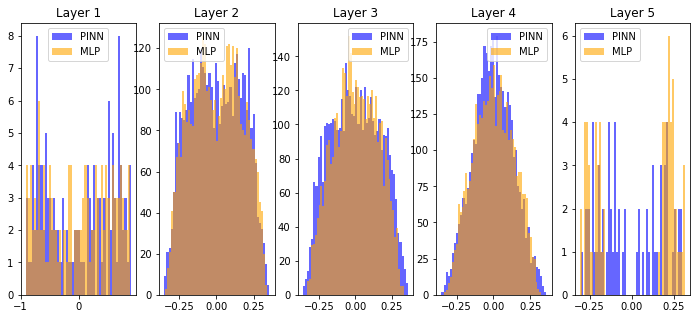

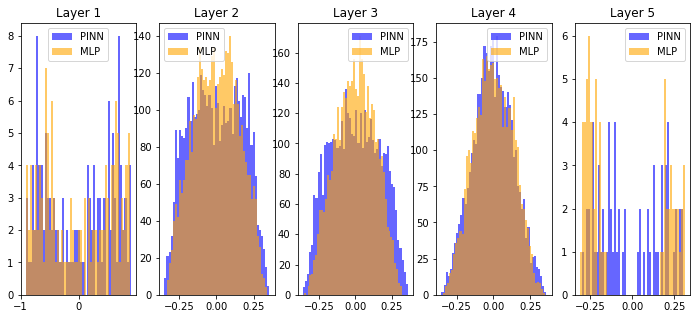

In [16]:
input_dim = 1
hidden_dim = 10
output_dim = 1
pinn_tiny = pinn_field(loc=r"D:\3ACS\TDL\lipEstimation\models_ckpts\pinn_field_tiny.pth", size = "tiny")
mlp_tiny = pinn_field(loc=r"D:\3ACS\TDL\lipEstimation\models_ckpts\mlp_field_tiny.pth", size = "tiny")
ridge_tiny = pinn_field(loc=r"D:\3ACS\TDL\lipEstimation\models_ckpts\ridge_field_tiny.pth", size = "tiny")

# Generate synthetic data
input_data = torch.linspace(0, 3, 100).reshape(-1, 1)

# Compare PINN and MLP
compare_pinn_mlp(pinn_tiny, mlp_tiny, input_data)
compare_pinn_mlp(pinn_tiny, ridge_tiny, input_data)


Pinn
Ratio = 0.94
torch.Size([64, 2]) torch.Size([64, 64])
Ratio = 0.99
torch.Size([64, 64]) torch.Size([64, 64])
Ratio = 0.89
torch.Size([64, 64]) torch.Size([64, 64])
Ratio = 0.94
torch.Size([64, 64]) torch.Size([64, 1])
MLP
Ratio = 0.93
torch.Size([64, 2]) torch.Size([64, 64])
Ratio = 0.93
torch.Size([64, 64]) torch.Size([64, 64])
Ratio = 0.83
torch.Size([64, 64]) torch.Size([64, 64])
Ratio = 0.70
torch.Size([64, 64]) torch.Size([64, 1])
Ridge
Ratio = 0.95
torch.Size([64, 2]) torch.Size([64, 64])
Ratio = 0.92
torch.Size([64, 64]) torch.Size([64, 64])
Ratio = 0.84
torch.Size([64, 64]) torch.Size([64, 64])
Ratio = 0.69
torch.Size([64, 64]) torch.Size([64, 1])
Cumulative similarities : MLP 0.0001460822341580541 || RIDGE 7.549290248226634e-06 || PINN 3.885974600596255e-06


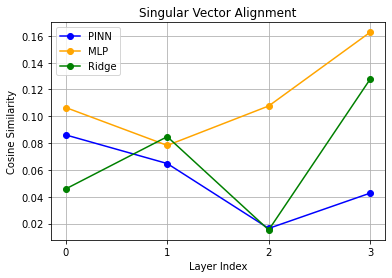

In [25]:
print("Pinn")
pinn_alignment_tiny = compute_alignment(pinn_tiny)
print("MLP")
mlp_alignment_tiny = compute_alignment(mlp_tiny)
print("Ridge")
ridge_alignment_tiny = compute_alignment(ridge_tiny)

print(f"Cumulative similarities : MLP {np.prod(mlp_alignment_tiny)} || RIDGE {np.prod(ridge_alignment_tiny)} || PINN {np.prod(pinn_alignment_tiny)}" )

plt.plot(pinn_alignment_tiny, label='PINN', marker='o', color='blue')
plt.plot(mlp_alignment_tiny, label='MLP', marker='o', color='orange')
plt.plot(ridge_alignment_tiny, label='Ridge', marker='o', color='green')
plt.title('Singular Vector Alignment')
plt.xlabel('Layer Index')
plt.ylabel('Cosine Similarity')
plt.legend()
plt.grid("on")
plt.xticks(ticks=range(len(pinn_alignment_tiny)))
plt.show()

In [18]:
mlp_big = pinn_field(loc=r"D:\3ACS\TDL\lipEstimation\models_ckpts\mlp_field_big.pth", size = "big")
pinn_big = pinn_field(loc=r"D:\3ACS\TDL\lipEstimation\models_ckpts\pinn_field_big.pth", size = "big")
ridge_big = pinn_field(loc=r"D:\3ACS\TDL\lipEstimation\models_ckpts\ridge_field_big.pth", size = "big")
lips_mlp_big = compute_lipschitz_approximations(mlp_big, [1,2])
lips_pinn_big = compute_lipschitz_approximations(pinn_big, [1,2])
lips_ridge_big = compute_lipschitz_approximations(ridge_big, [1,2])

NewPlanetsModel(
  (fc): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): Tanh()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): Tanh()
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): Tanh()
    (8): Linear(in_features=128, out_features=128, bias=True)
    (9): Tanh()
    (10): Linear(in_features=128, out_features=128, bias=True)
    (11): Tanh()
    (12): Linear(in_features=128, out_features=128, bias=True)
    (13): Tanh()
    (14): Linear(in_features=128, out_features=1, bias=True)
  )
)
Computing lip_opt...
 => New maximum: 1.1836 step size: 0.7071
[0] Best: 1.1836 (moves: 0/1, T: 1.44) (max: 1.1836)
 => New maximum: 9.2656 step size: 0.5774
[1] Best: 9.2656 (moves: 1/1, T: 1.09) (max: 9.2656)
 => New maximum: 9.9688 step size: 0.5000
[2] Best: 9.9688 (moves: 1/1, T: 0.91) (max: 9.9688)
[3] Best: 9.9688 (moves: 0/1, T: 0.80) (ma

d:\anaconda3\envs\dl_env\lib\site-packages\torch\nn\modules\module.py:1053: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


factor abs prod: 0.5400813113956247
factor 0.507278178949868
ratio s 0.9050403
factor abs prod: 0.3814414597582072
factor 0.609604968662159
ratio s 0.87718064
factor abs prod: 0.467045626071922
factor 0.6516604799207489
ratio s 0.53572613
factor abs prod: 0.7891641546848405
factor 0.5952566798334876
ratio s 0.3856512
factor abs prod: 0.9231239707855821
factor 0.5665045031659849
ratio s 0.27815938
factor abs prod: 0.8997498064527463
factor 0.5124413894472248
Computing lip_secorder BFGS...
ratio s 0.85528356
factor abs prod: 0.5400813113956247
factor 0.4965328424406472
ratio s 0.9050403
factor abs prod: 0.3814414597582072
factor 0.6065215202805576
ratio s 0.87718064
factor abs prod: 0.467045626071922
factor 0.6468528001610893
ratio s 0.53572613
factor abs prod: 0.7891641546848405
factor 0.5896423744828418
ratio s 0.3856512
factor abs prod: 0.9231239707855821
factor 0.5625873029297
ratio s 0.27815938
factor abs prod: 0.8997498064527463
factor 0.5104149478646319
NewPlanetsModel(
  (fc): Se

In [19]:
print("MLP: ", lips_mlp_big)
print("Ridge :", lips_ridge_big)
print("PINN: ", lips_pinn_big)

MLP:  {'Annealing lb': 19.765625, 'Spectral ub': 1900.0030517578125, 'Frobenius ub': 1262085.875, 'Seqlip greedy': 66.16405834276479, 'Seqlip bfgs': 62.66944993423673}
Ridge : {'Annealing lb': 16.7734375, 'Spectral ub': 130.559814453125, 'Frobenius ub': 204.6817626953125, 'Seqlip greedy': 0.17447800838077374, 'Seqlip bfgs': 0.14899588476440068}
PINN:  {'Annealing lb': 6.61328125, 'Spectral ub': 970.3617553710938, 'Frobenius ub': 939829.9375, 'Seqlip greedy': 46.088851435318595, 'Seqlip bfgs': 43.7369077659353}


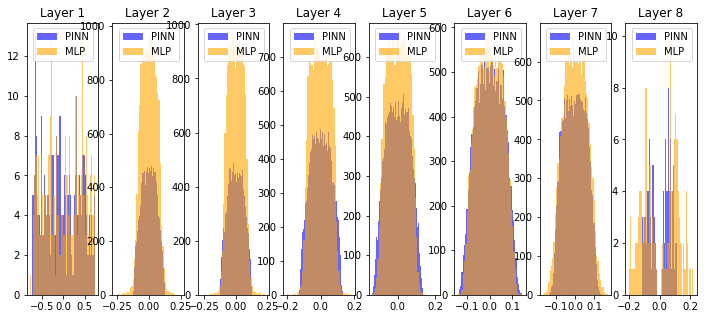

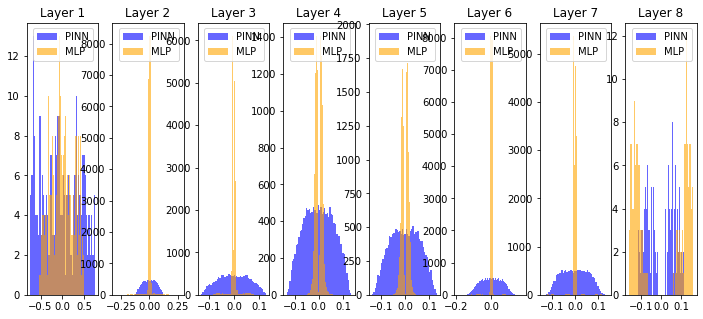

In [23]:
input_dim = 1
hidden_dim = 10
output_dim = 1
pinn_big = pinn_field(loc=r"D:\3ACS\TDL\lipEstimation\models_ckpts\pinn_field_big.pth", size = "big")
mlp_big = pinn_field(loc=r"D:\3ACS\TDL\lipEstimation\models_ckpts\mlp_field_big.pth", size = "big")
ridge_big = pinn_field(loc=r"D:\3ACS\TDL\lipEstimation\models_ckpts\ridge_field_big.pth", size = "big")

# Generate synthetic data
input_data = torch.linspace(0, 3, 100).reshape(-1, 1)

# Compare PINN and MLP
compare_pinn_mlp(pinn_big, mlp_big, input_data)
compare_pinn_mlp(pinn_big, ridge_big, input_data)

Pinn
Ratio = 0.97
torch.Size([128, 2]) torch.Size([128, 128])
Ratio = 0.96
torch.Size([128, 128]) torch.Size([128, 128])
Ratio = 0.96
torch.Size([128, 128]) torch.Size([128, 128])
Ratio = 0.93
torch.Size([128, 128]) torch.Size([128, 128])
Ratio = 0.87
torch.Size([128, 128]) torch.Size([128, 128])
Ratio = 0.85
torch.Size([128, 128]) torch.Size([128, 128])
Ratio = 0.78
torch.Size([128, 128]) torch.Size([128, 1])
MLP
Ratio = 0.94
torch.Size([128, 2]) torch.Size([128, 128])
Ratio = 0.86
torch.Size([128, 128]) torch.Size([128, 128])
Ratio = 0.91
torch.Size([128, 128]) torch.Size([128, 128])
Ratio = 0.88
torch.Size([128, 128]) torch.Size([128, 128])
Ratio = 0.54
torch.Size([128, 128]) torch.Size([128, 128])
Ratio = 0.39
torch.Size([128, 128]) torch.Size([128, 128])
Ratio = 0.28
torch.Size([128, 128]) torch.Size([128, 1])
Ridge
Ratio = 0.83
torch.Size([128, 2]) torch.Size([128, 128])
Ratio = 0.61
torch.Size([128, 128]) torch.Size([128, 128])
Ratio = 0.05
torch.Size([128, 128]) torch.Size([128

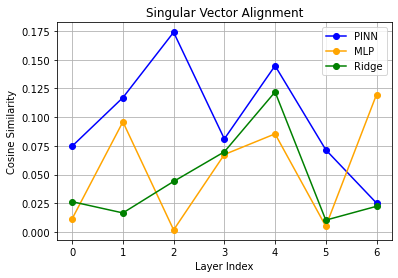

In [27]:
print("Pinn")
pinn_alignment = compute_alignment(pinn_big)
print("MLP")
mlp_alignment = compute_alignment(mlp_big)
print("Ridge")
ridge_alignment = compute_alignment(ridge_big)

print(f"Cumulative similarities : MLP {np.prod(mlp_alignment)} || Ridge {np.prod(ridge_alignment)} || PINN {np.prod(pinn_alignment)}" )

plt.plot(pinn_alignment, label='PINN', marker='o', color='blue')
plt.plot(mlp_alignment, label='MLP', marker='o', color='orange')
plt.plot(ridge_alignment, label='Ridge', marker='o', color='green')
plt.title('Singular Vector Alignment')
plt.xlabel('Layer Index')
plt.ylabel('Cosine Similarity')
plt.legend()
plt.grid("on")
plt.xticks(ticks=range(len(pinn_alignment)))
plt.show()